# Classificazione immagini

In [32]:
import numpy as np
import albumentations as A
from PIL import Image
import os

import matplotlib.pyplot as plt

import torch
import keras

## Dataset

prima di tutto definiamo in automatico le classi tramite il nome delle cartelle

In [33]:
cartella_data = "data"
batch_size = 16
augmentation = True

# salvo il nome delle classi in una lista
class_names = os.listdir(cartella_data)
class_names.sort() # ordino la lista in ordine alfabetico

print("le classi sono: ", class_names)
print("numero di classi: ", len(class_names))

le classi sono:  ['biscotti', 'caffè', 'modella', 'pizza']
numero di classi:  4


ora visualizziamo lo sbilanciamento delle classi

In [34]:
# creo un dizionario con le classi e il numero di immagini per classe
classi = {}
for classe in class_names:
    classi[classe] = len(os.listdir(os.path.join(cartella_data, classe)))

# stampo il numero di immagini per classe, e la relativa percentuale
for classe in class_names:
    print("classe: ", classe, "\nnumero di immagini: ", classi[classe], "\npercentuale: ", round(classi[classe]/sum(classi.values()), 3), "\n______________________")

classe:  biscotti 
numero di immagini:  10 
percentuale:  0.159 
______________________
classe:  caffè 
numero di immagini:  25 
percentuale:  0.397 
______________________
classe:  modella 
numero di immagini:  15 
percentuale:  0.238 
______________________
classe:  pizza 
numero di immagini:  13 
percentuale:  0.206 
______________________


## Generatore

dimensione del batch:  (16, 1024, 1024, 3)
dimensione del batch:  (16,)
________________________
esempio di immagine: 


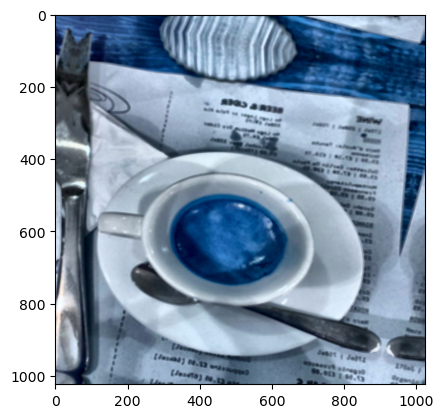

relativa label:  1
label decodificata:  caffè
________________________
________________________
valore minimo:  0.0
valore massimo:  1.0


In [75]:
def generatore_batch_classification(cartella = "data", batch_size = 16, dimensione_output = (256,256),  augmentation = True):
    '''
    Generatore che restituisce un batch di immagini e le rispettive label

    Parametri
    ----------
    cartella_data : string
        path della cartella contenente le immagini
    batch_size : int
        dimensione del batch di immagini che vogliamo ottenere
    augmentation : bool
        se True, applica data augmentation alle immagini
    
    Yields
    ------
    camera_batch : numpy array
        batch di immagini della camera
    classi_batch : numpy array
        batch di classi corrispondenti alle immagini
    '''
    buffer = batch_size
    #________________
    # PREPARAZIONE
    #________________
    dict_classi = {}
    for i,classe in enumerate(os.listdir(cartella)):
        dict_classi[classe] = i

    # creo una lista con la path relativa di ogni immagine
    lista_immagini = []
    for classe in dict_classi.keys():
        lista_immagini += [os.path.join(cartella, classe, immagine) for immagine in os.listdir(os.path.join(cartella, classe))]
    num_immagini = len(lista_immagini)

    if augmentation:
        #shuffle della lista
        np.random.shuffle(lista_immagini)




    #_______________________
    # GENERAZIONE BATCH
    #_______________________
    for batch in range(0, int(num_immagini), buffer):

        #gestisco il caso in cui l'ultimo batch non sia completo
        if batch + buffer > num_immagini:
            batch = num_immagini - buffer
        
        #inizializzo i batch
        batch_immagini = []
        batch_label = []

        #ciclo che scorre le immagini del batch
        for j in range(batch, batch + buffer):

            #apro l'immagine
            with Image.open(lista_immagini[j]) as immagine:
                immagine = np.array(immagine)
            

            #----------------------------------------------
            # LAVORO SULL'IMMAGINE
            immagine = A.Resize(dimensione_output[0], dimensione_output[1])(image = immagine)["image"]

            if augmentation:
                trasformazione = A.Compose([
                    A.HorizontalFlip(p = 0.5),
                    A.RandomBrightnessContrast(p = 0.2),
                    A.ShiftScaleRotate(p = 0.5),
                    A.GaussNoise(p = 0.5),
                    A.Blur(p = 0.5),
                    A.HueSaturationValue(p = 0.5),
                    A.RGBShift(p = 0.5),
                    A.RandomGamma(p = 0.5),
                    A.CLAHE(p = 0.5),
                    A.ChannelShuffle(p = 0.5)
                ])
                immagine = trasformazione(image = immagine)["image"]

            immagine = immagine/255  #normalizzo l'immagine
            #----------------------------------------------
            
            #leggo la label dalla path
            label = lista_immagini[j].split("\\")[1]
            #assegno l'id numerico alla label
            label = dict_classi[label]

            batch_immagini.append(immagine)
            batch_label.append(label)

        yield np.array(batch_immagini), np.array(batch_label)



# test
for camera_batch, classi_batch in generatore_batch_classification(cartella = "data", batch_size = 16, dimensione_output = (1024,1024), augmentation = True):
    print("dimensione del batch: ", camera_batch.shape)
    print("dimensione del batch: ", classi_batch.shape)
    print("________________________")
    print("esempio di immagine: ")
    plt.imshow(camera_batch[0])
    plt.show()
    print("relativa label: ", classi_batch[0])
    print("label decodificata: ", class_names[classi_batch[0]])
    print("________________________")
    print("________________________")
    print("valore minimo: ", np.min(camera_batch))
    print("valore massimo: ", np.max(camera_batch))
    break

In [36]:
# test del generatore

for camera_batch, classi_batch in generatore_batch_classification(cartella_data, batch_size, augmentation):
    print(camera_batch.shape)
    print(classi_batch.shape)
    break


(16, 256, 256, 3)
(16,)
